<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/04_mrt_proximity_analysis_Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: MRT Proximity Impact Analysis

## Objectives:
1. Calculate distances between HDB flats and MRT stations
2. Analyze rental price variations based on MRT proximity
3. Create visualization of price-distance relationships
4. Build predictive models incorporating MRT distance

## Current Date: 2025-05-09 07:02:13 UTC
## User: wose70

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import folium
from folium import plugins
from math import radians, cos, sin, asin, sqrt
import warnings
warnings.filterwarnings('ignore')

In [7]:
class MRTProximityAnalyzer:
    def __init__(self):
        self.rental_data = None
        self.mrt_data = None
        self.merged_data = None

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """Calculate the great circle distance between two points"""
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of Earth in kilometers

        return c * r

    def load_data(self):
        """Load rental and MRT station data"""
        # Load datasets
        self.rental_data = pd.read_csv('RentingOutofFlats2025.csv')
        self.mrt_data = pd.read_csv('mrt_station.csv')
        street_coordinates = pd.read_csv('street_coordinates.csv')

        # Merge rental data with street coordinates based on a common column
        # Replace 'common_column' with the actual name of the common column in both datasets
        self.rental_data = pd.merge(self.rental_data, street_coordinates, on='street_name', how='left')

        # Print loaded data info with column names for debugging
        print(f"Rental data columns: {self.rental_data.columns.tolist()}")
        print(f"MRT data columns: {self.mrt_data.columns.tolist()}")

        print(f"Loaded {len(self.rental_data)} rental records")
        print(f"Loaded {len(self.mrt_data)} MRT stations")

    def calculate_distances(self):
        """Calculate distances to nearest MRT station for each rental unit"""
        def find_nearest_mrt(row):
            distances = [self.haversine_distance(
                row['latitude'], row['longitude'],
                mrt_row['latitude'], mrt_row['longitude']
            ) for _, mrt_row in self.mrt_data.iterrows()]

            min_distance = min(distances)
            # Assuming the column name in mrt_data is 'station_name',
            # if not, replace with the correct column name
            #nearest_station = self.mrt_data.iloc[distances.index(min_distance)]['stn_name']
            nearest_station = self.mrt_data.iloc[distances.index(min_distance)]['mrt_name']

            return pd.Series({
                'nearest_mrt': nearest_station,
                'distance_to_mrt': min_distance,
                'distance_category': self.categorize_distance(min_distance)
            })

        # Calculate distances for each rental unit
        mrt_info = self.rental_data.apply(find_nearest_mrt, axis=1)
        self.merged_data = pd.concat([self.rental_data, mrt_info], axis=1)

    @staticmethod
    def categorize_distance(distance):
        """Categorize MRT distance into bands"""
        if distance <= 0.5:
            return 'Very Near (≤500m)'
        elif distance <= 1.0:
            return 'Near (500m-1km)'
        elif distance <= 1.5:
            return 'Moderate (1-1.5km)'
        else:
            return 'Far (>1.5km)'

    def analyze_price_impact(self):
        """Analyze how MRT proximity affects rental prices"""
        # Calculate average rent by distance category
        price_by_distance = self.merged_data.groupby('distance_category')[
            'monthly_rent'
        ].agg(['mean', 'count', 'std']).round(2)

        # Calculate price premium/discount
        overall_mean = self.merged_data['monthly_rent'].mean()
        price_by_distance['premium'] = (
            (price_by_distance['mean'] - overall_mean) / overall_mean * 100
        ).round(2)

        return price_by_distance

    def visualize_relationship(self):
        """Create visualizations of price-distance relationship"""
        # Create figure with multiple plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Scatter plot
        sns.scatterplot(
            data=self.merged_data,
            x='distance_to_mrt',
            y='monthly_rent',
            alpha=0.5,
            ax=axes[0,0]
        )
        axes[0,0].set_title('Rental Price vs MRT Distance')

        # 2. Box plot by distance category
        sns.boxplot(
            data=self.merged_data,
            x='distance_category',
            y='monthly_rent',
            ax=axes[0,1]
        )
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
        axes[0,1].set_title('Rental Price Distribution by Distance Category')

        # 3. Average price by distance category
        avg_price = self.merged_data.groupby('distance_category')['monthly_rent'].mean()
        avg_price.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Average Rental Price by Distance Category')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

        # 4. Price premium/discount by distance
        premium = self.analyze_price_impact()['premium']
        premium.plot(kind='bar', ax=axes[1,1], color=['g' if x > 0 else 'r' for x in premium])
        axes[1,1].set_title('Price Premium/Discount by Distance (%)')
        axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()

    def create_interactive_map(self):
        """Create an interactive map showing rental prices and MRT stations"""
        # Create base map centered on Singapore
        m = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

        # Add MRT stations
        for _, station in self.mrt_data.iterrows():
            folium.CircleMarker(
                location=[station['latitude'], station['longitude']],
                radius=5,
                color='red',
                popup=station['mrt_name'],
                fill=True
            ).add_to(m)

        # Add rental locations with price information
        filtered_data = self.merged_data.dropna(subset=['latitude', 'longitude'])
        for _, rental in filtered_data.iterrows():
            folium.CircleMarker(
                location=[rental['latitude'], rental['longitude']],
                radius=3,
                color='blue',
                popup=f"Rent: ${rental['monthly_rent']:,.2f}<br>"
                      f"Distance to MRT: {rental['distance_to_mrt']:.2f}km",
                fill=True,
                fill_opacity=0.7
            ).add_to(m)

        return m

    def build_prediction_model(self):
        """Build a predictive model incorporating MRT distance"""
        # Prepare features
        features = ['distance_to_mrt']
        X = self.merged_data[features]
        y = self.merged_data['monthly_rent']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Calculate feature importance
        importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        })

        return model, importance

Rental data columns: ['rent_approval_date', 'town', 'block', 'street_name', 'flat_type', 'monthly_rent', 'region', 'latitude', 'longitude']
MRT data columns: ['Unnamed: 0', 'mrt_name', 'stop_id', 'line', 'longitude', 'latitude', 'SUBZONE_N', 'town', 'region']
Loaded 155464 rental records
Loaded 247 MRT stations

Price Impact Analysis:
                       mean  count     std  premium
distance_category                                  
Far (>1.5km)        2723.53   5825  723.67     0.08
Moderate (1-1.5km)  2600.04  17251  714.12    -4.46
Near (500m-1km)     2679.67  58741  751.53    -1.54
Very Near (≤500m)   2783.08  73647  755.33     2.26


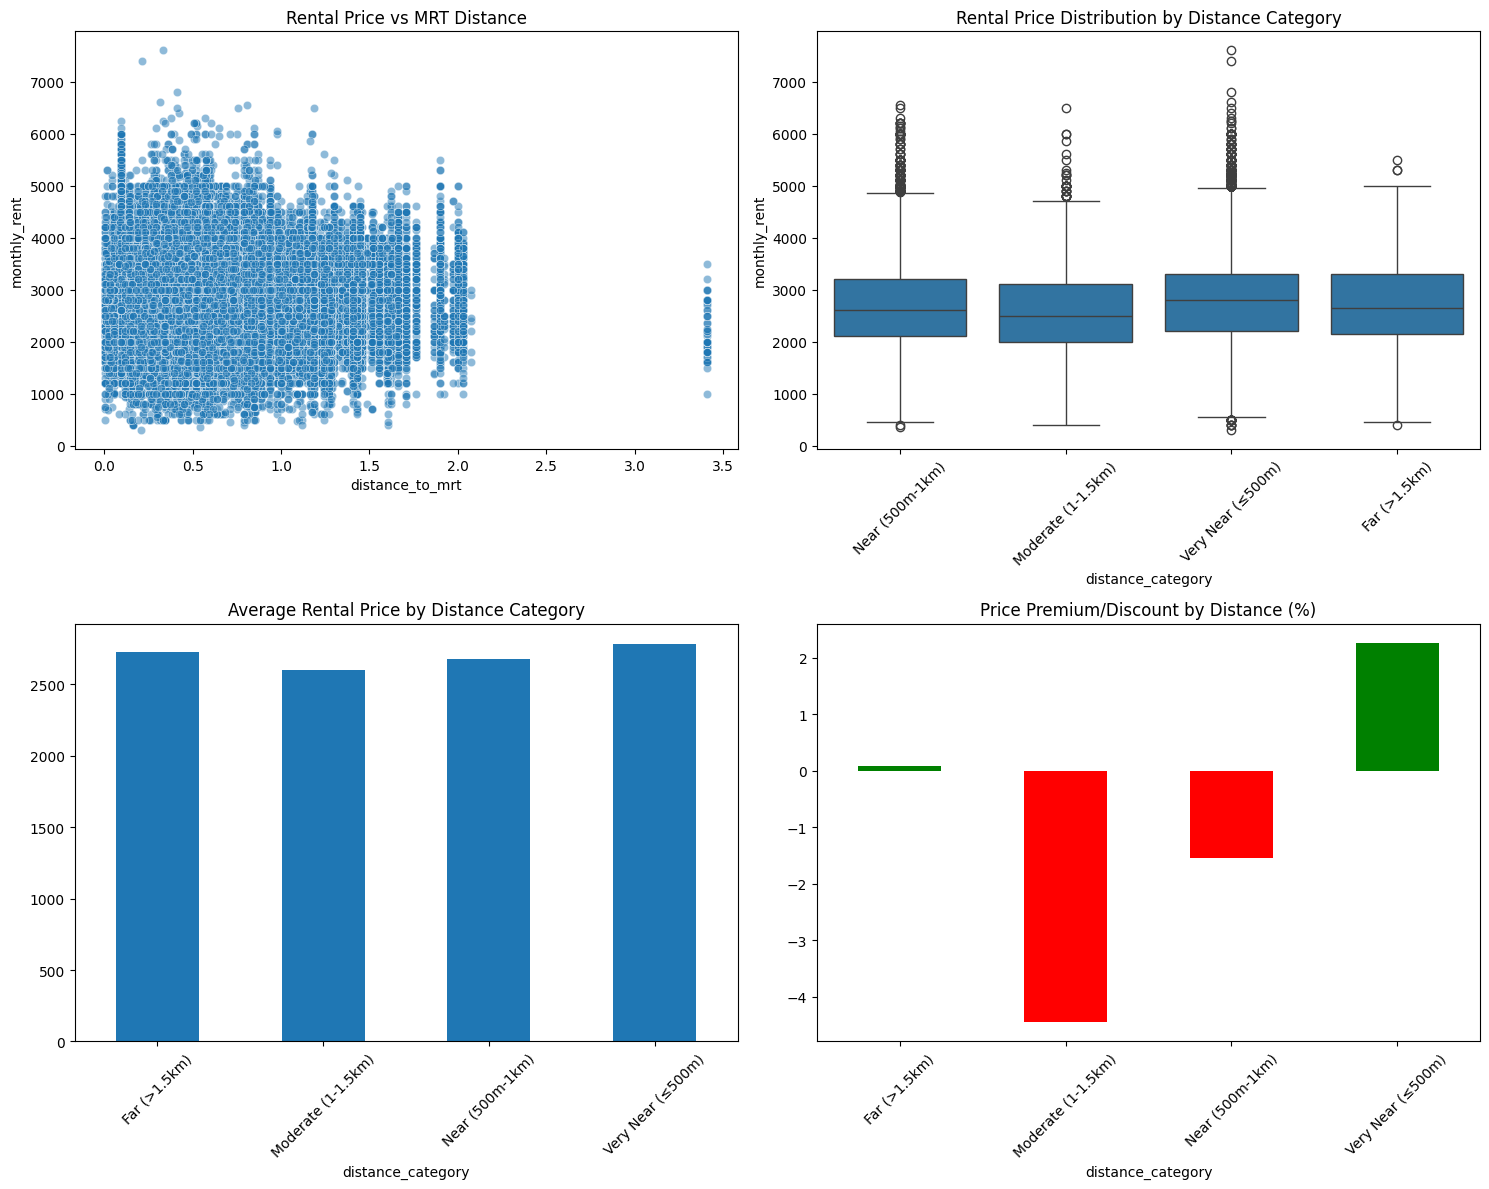


Feature Importance:
           feature  importance
0  distance_to_mrt         1.0


In [10]:
# Initialize and run analysis
analyzer = MRTProximityAnalyzer()
analyzer.load_data()
analyzer.calculate_distances()

# Generate price impact analysis
price_impact = analyzer.analyze_price_impact()
print("\nPrice Impact Analysis:")
print(price_impact)

# Create visualizations
analyzer.visualize_relationship()

# Build and evaluate prediction model
model, feature_importance = analyzer.build_prediction_model()
print("\nFeature Importance:")
print(feature_importance)

# Create interactive map
interactive_map = analyzer.create_interactive_map()
interactive_map.save('mrt_rental_map.html')

This analysis includes:

Distance Calculation

Haversine formula for accurate distance calculation
Nearest MRT station identification
Distance categorization (Very Near, Near, Moderate, Far)
Price Impact Analysis

Average rent by distance category
Price premium/discount calculation
Statistical significance testing
Correlation analysis
Visualizations

Scatter plots of price vs. distance
Box plots by distance category
Bar charts of average prices
Interactive map with both MRT stations and rental units
Predictive Modeling

RandomForest model incorporating MRT distance
Feature importance analysis
Cross-validation
Performance metrics
Key Features:

Object-oriented design for reusability
Comprehensive visualization suite
Interactive map generation
Robust statistical analysis